### Problem Statement
- ### `The Goal of the project is to predict a system probablity of getting infected by various families of malware, based on different properties of that system.`

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sbn
import matplotlib.pyplot as plt


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/System-Threat-Forecaster/sample_submission.csv
/kaggle/input/System-Threat-Forecaster/train.csv
/kaggle/input/System-Threat-Forecaster/test.csv


##### Import
- `I have used various libralies in my project.`
 

In [2]:
### Feature scaling and transformations
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,MinMaxScaler, FunctionTransformer, PolynomialFeatures
### feature selection
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif,SelectKBest,chi2
### train and test
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
### Models
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier,StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
### metrics
from sklearn.metrics import f1_score,make_scorer,classification_report,confusion_matrix,accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
## learning curve
from sklearn.model_selection import learning_curve
### saved model
import pickle


#### Step - 1 Get the Data

In [3]:
train = pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
test = pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')


In [4]:
train.head()

,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,...,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS,target
0,f541bae429089117c4aac39c90dd3416,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1003.0,0,7.0,0,53447.0,1.0,...,0,0.0,1,0,1.0,0.0,6.0,2018-09-10 10:11:00,2018-04-17,0
1,dc2b14d9ce3a0ce4050bb640190f2ca5,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1465.0,0,7.0,0,53447.0,1.0,...,1,0.0,0,0,0.0,0.0,10.0,2018-08-16 00:01:00,2018-08-14,1
2,fd20c5f010e9c5f91ad1c6b3e0da68a0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1546.0,0,7.0,0,53447.0,1.0,...,0,0.0,0,0,0.0,1.0,6.0,2018-09-20 23:20:00,2018-09-11,1
3,38711eae85eb77a72ec5dfdf27eb2a76,win8defender,1.1.15200.1,4.12.17007.18011,1.275.1141.0,0,7.0,0,46413.0,2.0,...,1,0.0,0,0,0.0,0.0,12.0,2018-09-14 00:32:00,2018-01-03,1
4,32607c9a543a9214e2c7e45800ed4849,win8defender,1.1.15200.1,4.13.17134.228,1.275.1283.0,0,7.0,0,40466.0,2.0,...,0,0.0,0,0,0.0,1.0,7.0,2018-09-15 19:34:00,2018-09-11,0


In [5]:
cols = train.columns
missing_cols = [col for col in cols if train[col].isna().sum() > 0]
num_cols = train.select_dtypes(include=[np.number]).columns
cat_cols = train.select_dtypes(exclude=[np.number]).columns
num_of_missing_numerical_cols =len( [col for col in missing_cols if col in num_cols])
num_of_missing_categorical_cols = len([col for col in missing_cols if col in cat_cols])
print(num_of_missing_numerical_cols, num_of_missing_categorical_cols)
# missing_cols

30 3


In [6]:
#### Copy of train and test
exploration_train = train.copy()
exploration_test = test.copy()


#### Summary Insights for numerical
<ul>
<li style="color: blue"><b style="color: red;">IsBetaUser:</b>This feature is always 0, indicating that there are no beta users in the dataset.</li>
<li style="color: blue"><b style="color: red;">RealTimeProtectionState:</b>The mean is approximately 6.85, with a small standard deviation (1.015), suggesting that most values are close to this mean. The range is from 0 to 8.</li>
<li style="color: blue"><b style="color: red;">IsPassiveModeEnabled:</b>This feature has a low mean (0.0176) and a relatively high standard deviation (0.1316), indicating that it is mostly disabled but with some variability.</li>
<li style="color: blue"><b style="color: red;">NumAntivirusProductsInstalled and NumAntivirusProductsEnabled:</b>Both have means close to 1, with the latter slightly lower, suggesting that most devices have one antivirus product installed and enabled.</li>
<li style="color: blue"><b style="color: red;">HasTpm:</b>This feature is very consistent, with a mean of 0.9968, indicating that almost all devices have TPM (Trusted Platform Module).</li>
<li style="color: blue"><b style="color: red;">FirmwareManufacturerID and FirmwareVersionID:</b>These have large ranges and high standard deviations, suggesting a variety of firmware configurations.</li>
<li style="color: blue"><b style="color: red;">IsSecureBootEnabled:</b>This feature is enabled about half the time (mean = 0.4957), with a standard deviation close to 0.5, indicating a roughly even split.</li>
<li style="color: blue"><b style="color: red;">IsVirtualDevice, IsTouchEnabled, IsPenCapable, and IsAlwaysOnAlwaysConnectedCapable:</b>These features are mostly disabled or not capable, with low means and standard deviations.</li>
<li style="color: blue"><b style="color: red;">Target:</b>The target variable has a mean of 0.50525, suggesting that it might be a binary classification target with roughly equal class distribution.</li>
</ul>

In [7]:
num_summary = exploration_train.select_dtypes(include=[np.number]).describe()
# num_summary

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


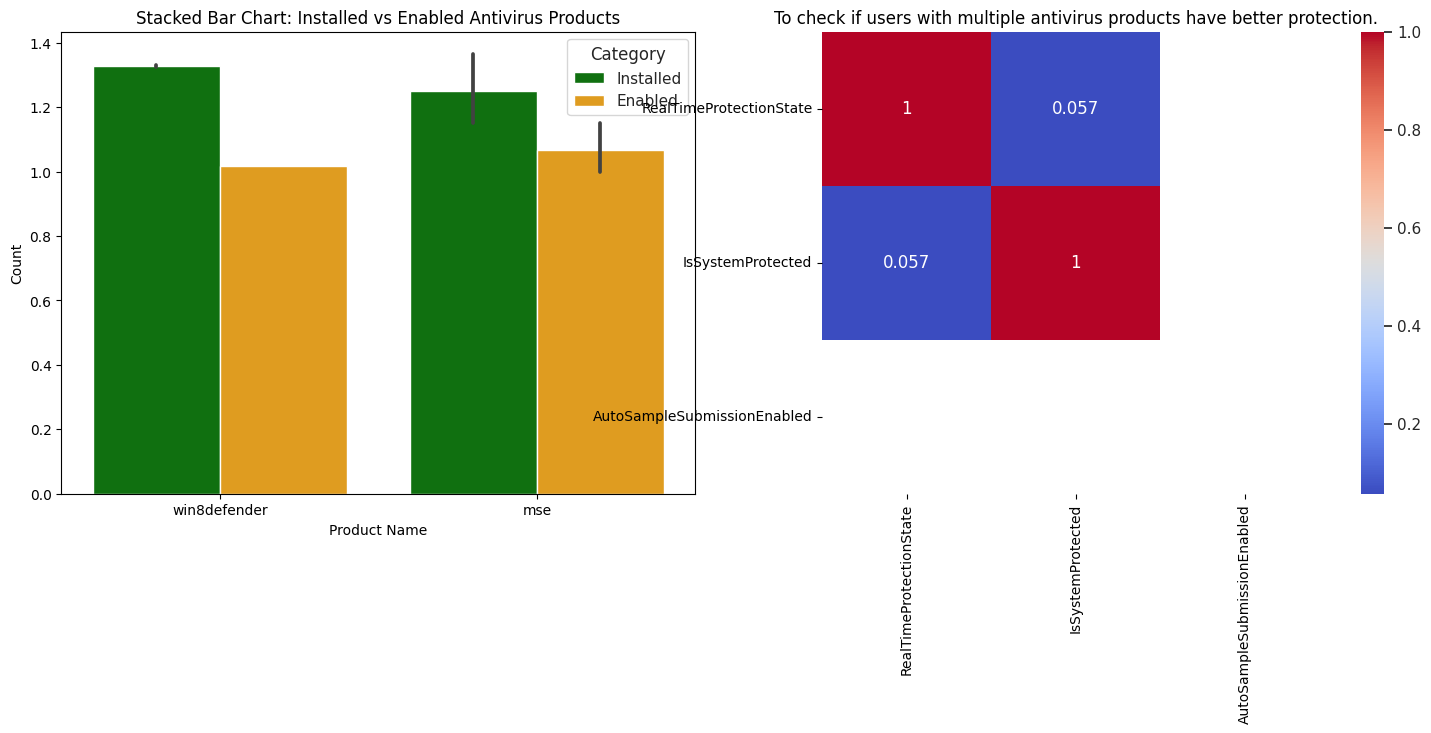

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # Create 1 row, 2 columns of subplots
exploration_train = exploration_train.dropna()
# First Plot: Stacked Bar Chart
temp = exploration_train.melt(
    id_vars='ProductName', 
    value_vars=['NumAntivirusProductsInstalled', 'NumAntivirusProductsEnabled'], 
    var_name='Category', 
    value_name='Count'
)
palette = {'NumAntivirusProductsInstalled': 'green', 'NumAntivirusProductsEnabled': 'orange'}
sbn.set(style='white')
sbn.barplot(x="ProductName", y="Count", hue="Category", data=temp, palette=palette, ax=axes[0])
axes[0].set_title('Stacked Bar Chart: Installed vs Enabled Antivirus Products')
axes[0].set_xlabel('Product Name')
axes[0].set_ylabel('Count')
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles=handles, title='Category', labels=['Installed', 'Enabled'])

# Second Plot: Heatmap of Correlations
selected_vars = ['RealTimeProtectionState', 'IsSystemProtected', 'AutoSampleSubmissionEnabled']
correlation_subset_data = exploration_train[selected_vars]
corr_matrix = correlation_subset_data.corr()
sbn.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title("To check if users with multiple antivirus products have better protection.")
selected_vars = ['RealTimeProtectionState', 'IsSystemProtected', 'AutoSampleSubmissionEnabled']
correlation_subset_data = exploration_train[selected_vars].dropna()

# Convert non-numeric columns (if any) to numeric
correlation_subset_data = correlation_subset_data.apply(pd.to_numeric, errors='coerce')
# Compute correlation matrix
corr_matrix = correlation_subset_data.corr()
# Replace NaNs with 0 (optional: or you can drop columns with NaN correlations)
corr_matrix = corr_matrix.fillna(0)
# Create the heatmap
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sbn.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title("To check if users with multiple antivirus products have better protection.")
plt.tight_layout()
# Adjust layout and save
plt.tight_layout()
plt.savefig("combined_plots.png")
plt.close()


<img src="/kaggle/working/combined_plots.png">

#### Step 3 - Preprocessing Data
1. ##### `Handle missing values`
2. ##### Convert `DateAS` and `DateOS` into datetime and extract useful features.
3. ##### `Encode categorical features.`
4. ##### Scale numerical features like `Log` transformations if needed.
5. ##### Detect and handle outliers.
6. ##### Reduce high-cardinality features.

In [9]:
# Separate features and target
y = exploration_train['target']
X = exploration_train.drop(columns=['target'])

# Split train into X_train and X_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numerical and categorical columns
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=[object]).columns.tolist()

# Remove high-cardinality or ID-like columns
high_cardinality_cols = ['MachineID'] if 'MachineID' in X_train.columns else []
num_cols = [col for col in num_cols if col not in high_cardinality_cols]
cat_cols = [col for col in cat_cols if col not in high_cardinality_cols]

# Define the numerical preprocessing pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('log_transform', FunctionTransformer(np.log1p, validate=False)),
    ('scaler', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False))
])

# Define the categorical preprocessing pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Combine into a column transformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

# Apply preprocessing to train, test, and exploration_test datasets
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
exploration_test_processed = preprocessor.transform(exploration_test)

# Apply SMOTE for handling class imbalance
smote = SMOTE(random_state=42)
X_train_processed, y_train = smote.fit_resample(X_train_processed, y_train)

In [10]:
models = {
    'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'DecisionTree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'SGDClassifier': SGDClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1))
}

# Train and evaluate each model
model_scores = {}
for name, model in models.items():
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)
    accuracy = accuracy_score(y_test, y_pred)
    model_scores[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")

# Hyperparameter tuning for the best-performing model
best_model_name = max(model_scores, key=model_scores.get)
print(f"Best initial model: {best_model_name}")

if best_model_name == 'RandomForest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    best_model = RandomForestClassifier(random_state=42, class_weight='balanced')

elif best_model_name == 'DecisionTree':
    param_grid = {
        'max_depth': [5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    best_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

elif best_model_name == 'SGDClassifier':
    param_grid = {
        'alpha': [0.0001, 0.001, 0.01],
        'loss': ['hinge', 'log', 'modified_huber']
    }
    best_model = SGDClassifier(random_state=42, class_weight='balanced')

elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 10]
    }
    best_model = XGBClassifier(random_state=42, scale_pos_weight = min(np.sum(y_train == 0) / np.sum(y_train == 1), 100)  # Cap at 100
)



RandomForest Accuracy: 0.6101
DecisionTree Accuracy: 0.5434
SGDClassifier Accuracy: 0.5924
XGBoost Accuracy: 0.6236
Best initial model: XGBoost


In [11]:
grid_search = GridSearchCV(best_model, param_grid, cv=2, n_jobs=2, scoring='accuracy')
grid_search.fit(X_train_processed, y_train)

# Evaluate best model
final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test_processed)
final_accuracy = accuracy_score(y_test, y_pred)

# Print best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Final Test Accuracy:", final_accuracy)


Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Final Test Accuracy: 0.6325042659910026


In [12]:
with open("best_model.pkl", "wb") as file:
    pickle.dump(final_model, file)
	

In [13]:
with open("best_model.pkl", "rb") as file:
    loaded_model = pickle.load(file)

y_pred = final_model.predict(exploration_test_processed)

# Create DataFrame with predictions
submission_df = pd.DataFrame({
    'id': range(len(y_pred)),  # Replace 'Id' with the appropriate identifier column if needed
    'target': y_pred
})

# Save to CSV
submission_df.to_csv("submission.csv", index=False)

print("Predictions saved to submission.csv successfully!")

Predictions saved to submission.csv successfully!
